# LAB 6: NN5: Testing different activation functions (1 week, 2 points)

Extend an existing network and learning method implementation to include a choice of activation functions:
* sigmoid,
* linear,
* tanh,
* ReLU.

Additional question - does everyone implement exactly the gradient for the ReLU function?

Compare the learning speed and efficiency of the network depending on the number of neurons in each layer and the type of activation function. Consider that different activation functions can give different efficiency depending on the number of neurons and the number of layers. Check networks with one, two and three hidden layers. As in the previous week, you need to adapt the learning process to the derivatives of the new activation functions.


Conduct preliminary tests for the multimodal-large set (regression), for all three architectures and all four activation functions.


For the other sets, select the two best sets and test their effectiveness:

regression
* steps-large,

classification
* rings5-regular
* rings3-regular

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, mean_squared_error
import copy
from scipy.special import expit
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
def sigmoid(x):
    return expit(x)

def sigmoid_prime(x):
    return expit(x)*(1 - expit(x))

def linear(x):
    return x

def linear_prime(x):
    return np.ones(x.shape)

def relu(x): 
    return np.maximum(x, 0)

def relu_prime(x): 
    return np.where(x > 0, 1, 0)

def tanh(x):
    return (expit(x) - expit(-x)) / (expit(x) + expit(-x))

def tanh_prime(x):
    return 1.0 - tanh(x)**2
   

def softmax(x):
    e_x = expit(x.T - np.max(x, axis=1).T).T
    return (e_x.T / e_x.sum(axis=1).T).T


In [3]:
def generate_weights_and_biases(layers, init_method):
    biases = []
    weights = []
    if init_method == 'uniform':
        for i in range(1, len(layers)):
            np.random.seed(123)
            weights.append(np.random.uniform(low=-1.0, high=1.0, size=(layers[i-1], layers[i])))
            biases.append(np.zeros((1, layers[i])))
    elif init_method == 'Xavier':
        for i in range(1, len(layers)):
            np.random.seed(123)
            weights.append(np.random.randn(layers[i-1], layers[i]) * np.sqrt(1/layers[i-1]))
            biases.append(np.random.randn(1, layers[i])*np.sqrt(1/(layers[i-1])))
    elif init_method == 'He':
        for i in range(1, len(layers)):
            np.random.seed(777)
            weights.append(np.random.randn(layers[i-1], layers[i]) * np.sqrt(2/layers[i-1]))
            biases.append(np.random.randn(1, layers[i])*np.sqrt(2/(layers[i-1])))
                          
    return weights, biases

In [4]:
def feedforward(x, weights, biases, activation_fun='sigmoid', activation_fun_out='linear'):
    activations = [x]
    zs = []
    
    if activation_fun =='sigmoid':
        activate = sigmoid
    elif activation_fun =='linear':
        activate = linear
    elif activation_fun == 'tanh':
        activate = tanh
    elif activation_fun == 'relu':
        activate = relu
    else:
        print('Incorrect value of the activation parameter')

    for j in range(len(weights)-1):
        z = np.dot(activations[-1], weights[j]) + biases[j]
        zs.append(z)
        activation = activate(z)
        activations.append(activation)

    z = np.dot(activations[-1], weights[-1]) + biases[-1]
    zs.append(z)
    if activation_fun_out == 'softmax':
        activation = softmax(z)
    elif activation_fun_out == 'linear':
        activation = linear(z)
    activations.append(activation)
    return activations, zs


In [5]:
def backpropagation(y, weights, activations, zs, layers, activation_fun='sigmoid', activation_fun_out='linear'):
    deltas = [None] * len(weights)
    if activation_fun_out == 'softmax':
        result = []
        for e_x, e_y in zip(activations[-1], y):
            error = e_y - e_x
            x = e_x.reshape(e_x.shape[0], )
            si_sj = - x * x.reshape(layers[-1], 1)
            s_der = np.diag(x) + si_sj
            result.append(s_der @ error)
        result = np.array(result)
        deltas[-1] = copy.deepcopy(result)
    elif activation_fun_out == 'linear':
        deltas[-1] = y - activations[-1]

    if activation_fun =='sigmoid':
        activation_derivative = sigmoid_prime
    elif activation_fun =='linear':
        activation_derivative = linear_prime
    elif activation_fun == 'tanh':
        activation_derivative = tanh_prime
    elif activation_fun == 'relu':
        activation_derivative = relu_prime
    else:
        print('Incorrect value of the activation parameter')

    for i in reversed(range(len(deltas) - 1)):
        deltas[i] = ((weights[i + 1] @ deltas[i + 1].T) * activation_derivative(zs[i]).T).T

    y_size = y.shape[0]
    biases_prime = [None] * len(deltas)
    weights_prime = [None] * len(deltas)

    for i in range(len(deltas)):
        weights_prime[i] = np.dot(deltas[i].T, activations[i]).T / y_size
        biases_prime[i] = np.dot(deltas[i].T, np.ones((y_size, 1))).T / y_size

    return weights_prime, biases_prime

In [6]:
def update_weights_biases(weights, biases, learning_rate, weights_prime, biases_prime, method, lambda_moment=None, momentum_w=None, momentum_b=None, beta_rms=None, grad_sq_w=None, grad_sq_b=None):

    for i in range(len(weights)):

            if method == 'SGD':
                weights[i] += learning_rate * weights_prime[i]
                biases[i] += learning_rate * biases_prime[i]
                
            elif method == 'momentum':
                momentum_w[i] = weights_prime[i] + lambda_moment * momentum_w[i]
                weights[i] += learning_rate * momentum_w[i]
                momentum_b[i] = biases_prime[i] + lambda_moment * momentum_b[i]
                biases[i] += learning_rate * momentum_b[i]

            elif method == 'RMSProp':
                grad_sq_w[i] = beta_rms*grad_sq_w[i] + (1-beta_rms)*weights_prime[i]**2
                weights[i] += learning_rate * (weights_prime[i] / np.sqrt(grad_sq_w[i]))
                grad_sq_b[i] = beta_rms*grad_sq_b[i] + (1-beta_rms)*biases_prime[i]**2
                biases[i] += learning_rate * (biases_prime[i] / np.sqrt(grad_sq_b[i])) 
                
    return weights, biases

In [7]:
def train(x, y, x_test, y_test, layers, epochs, learning_rate, method, batch_size=None, init_method='uniform', lambda_moment=0.5, beta_rms=0.5, activation_fun='sigmoid', activation_fun_out='linear', scaler_y=None):

    weights, biases = generate_weights_and_biases(layers, init_method)
    p = np.random.permutation(len(y))

    if activation_fun_out == 'softmax':
        b = np.zeros((y.size, y.max() + 1))
        b[np.arange(y.size), y.flatten()] = 1
        y = b
        x = x[p]
        y = y[p]
    elif activation_fun_out == 'linear':
        x = x.iloc[p]
        y = y.iloc[p]

    momentum_w = [np.zeros(w.shape) for w in weights]
    momentum_b = [np.zeros(b.shape) for b in biases]
    grad_sq_w= [np.zeros(w.shape) for w in weights]
    grad_sq_b = [np.zeros(b.shape) for b in biases]

    losses = []
    for epoch in range(epochs):

        if batch_size != None:
            i = 0
            while i < len(y):
                x_batch = x[i:i + batch_size]
                y_batch = y[i:i + batch_size]
                i = i + batch_size
                activations, zs = feedforward(x_batch, weights, biases, activation_fun, activation_fun_out)
                weights_prime, biases_prime = backpropagation(y_batch, weights, activations, zs, layers, activation_fun, activation_fun_out)
                weights, biases = update_weights_biases(weights, biases, learning_rate, weights_prime, biases_prime, method, lambda_moment, momentum_w, momentum_b, beta_rms, grad_sq_w, grad_sq_b)
        else:
            activations, zs = feedforward(x, weights, biases, activation_fun, activation_fun_out)
            weights_prime, biases_prime = backpropagation(y, weights, activations, zs, layers, activation_fun, activation_fun_out)
            weights, biases = update_weights_biases(weights, biases, learning_rate, weights_prime, biases_prime, method, lambda_moment, momentum_w, momentum_b, beta_rms, grad_sq_w, grad_sq_b)            

        if epoch % 20 == 0:
            activations_test, zs_test = feedforward(x_test, weights, biases, activation_fun, activation_fun_out)
            activations_train, zs_train = feedforward(x, weights, biases, activation_fun, activation_fun_out)
            if activation_fun_out == 'linear':
                if scaler_y != None:
                    loss_train = mean_squared_error(scaler_y.inverse_transform(y), scaler_y.inverse_transform(activations_train[-1]))
                    loss_test = mean_squared_error(scaler_y.inverse_transform(y_test), scaler_y.inverse_transform(activations_test[-1]))
                else:
                    loss_train = mean_squared_error(y, activations_train[-1])
                    loss_test = mean_squared_error(y_test, activations_test[-1])
            elif activation_fun_out == 'softmax':
                loss_train = f1_score(np.argmax(y, axis=1), np.argmax(activations_train[-1], axis = 1), average='macro')
                loss_test = f1_score(y_test, np.argmax(activations_test[-1], axis = 1), average='macro')
            losses.append(loss_test)
            print("Epoch {}: Loss train: {} Loss test: {}".format(epoch, loss_train, loss_test), end='\r')  
            
    return weights, biases, losses

In [8]:
def scale_data(x, y, x_test, y_test):
    
    scaler_x = MinMaxScaler()
    scaler_x.fit(x)
    x = pd.DataFrame(scaler_x.transform(x))
    x_test = pd.DataFrame(scaler_x.transform(x_test))

    scaler_y= MinMaxScaler()
    scaler_y.fit(y)
    y = pd.DataFrame(scaler_y.transform(y))
    y_test = pd.DataFrame(scaler_y.transform(y_test))

    return x, y, x_test, y_test, scaler_y, scaler_x

In [9]:
def evaluate(x, y, x_test, y_test, layers, epochs, learning_rate, method, batch_size = None, scaling=False, init_method='uniform', lambda_moment=None, beta_rms=None, activation_fun='sigmoid', activation_fun_out='linear'):
    
    scaler_y = None
    scaler_x = None
    if scaling:
       x, y, x_test, y_test, scaler_y, scaler_x = scale_data(x, y, x_test, y_test)
    
    weights, biases, losses = train(x, y, x_test, y_test, layers, epochs, learning_rate, method, batch_size, init_method, lambda_moment, beta_rms, activation_fun, activation_fun_out, scaler_y)
       
    activations, zs = feedforward(x, weights, biases, activation_fun, activation_fun_out)
    activations_test, zs = feedforward(x_test, weights, biases, activation_fun, activation_fun_out)

    if scaling:
        predictions = scaler_y.inverse_transform(activations[-1]) 
        predictions_test = scaler_y.inverse_transform(activations_test[-1]) 
        y = scaler_y.inverse_transform(y)
        y_test = scaler_y.inverse_transform(y_test)
        x = scaler_x.inverse_transform(x)
        x_test = scaler_x.inverse_transform(x_test)
    else:
        predictions = activations[-1]
        predictions_test = activations_test[-1]
    
    print("MSE na zbiorze testowym:", mean_squared_error(y_test, predictions_test))
    
    plt.subplots(1, 2, figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.scatter(x, y, color='green')
    plt.scatter(x, predictions, color='red')
    plt.title("Zbiór treningowy")
    plt.subplot(1, 2, 2)
    plt.scatter(x_test, y_test, color='green')
    plt.scatter(x_test, predictions_test, color='red')
    plt.title("Zbiór testowy")
    plt.show()
    return losses, predictions, predictions_test

## tests on multimodel large

In [11]:
data_train = pd.read_csv('../data/regression/multimodal-large-training.csv')
data_test = pd.read_csv('../data/regression/multimodal-large-test.csv')
x = data_train[['x']]
y = data_train[['y']]
x_test = data_test[['x']]
y_test = data_test[['y']]

##### 1 layer, sigmoid

MSE na zbiorze testowym: 10.711464294264614oss test: 10.551024652843656


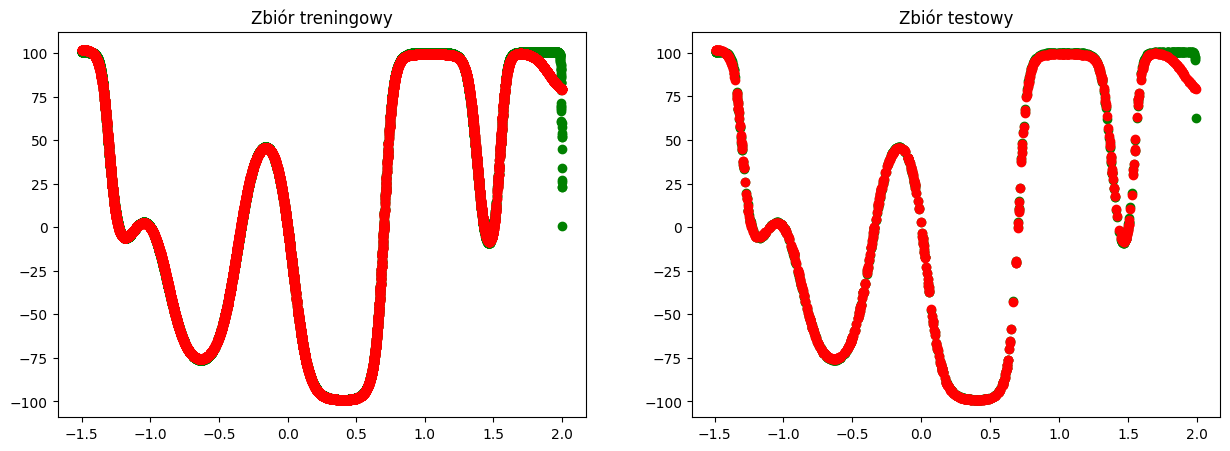

In [26]:
losses_1_s, predictions, predictions_test = evaluate(x, y, x_test, y_test, layers=[1, 30, 1], epochs=1000, learning_rate=0.02, method='SGD', batch_size=64, init_method='uniform')

##### 1 layer, linear

MSE na zbiorze testowym: 4624.843593484245oss test: 4624.8435934842455


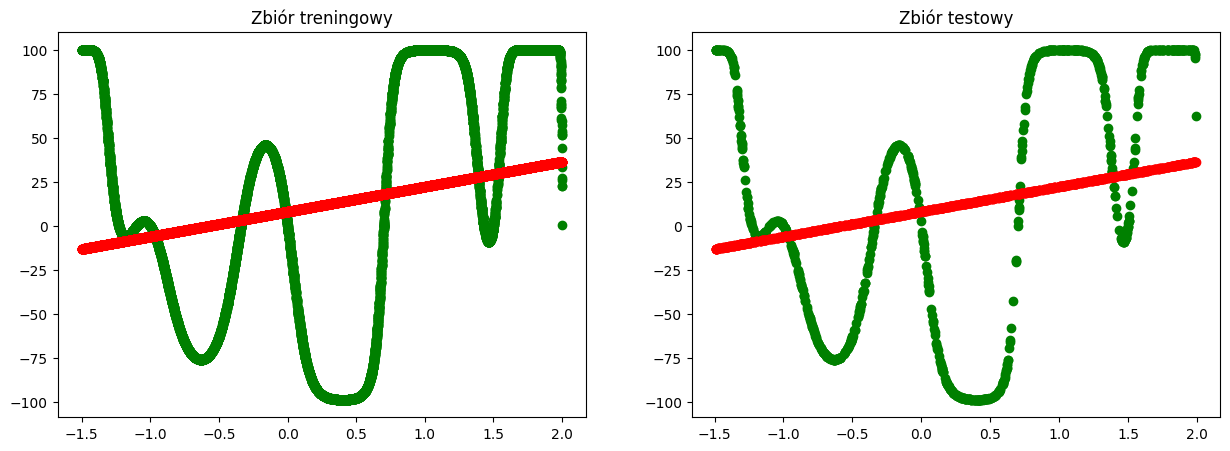

In [27]:
losses_1_l, predictions, predictions_test = evaluate(x, y, x_test, y_test, layers=[1, 30, 1], epochs=1000, learning_rate=0.02, method='SGD', batch_size=64, init_method='uniform', activation_fun='linear')

##### 1 layer, tanh

MSE na zbiorze testowym: 6.229780131707219Loss test: 6.2302551046031084


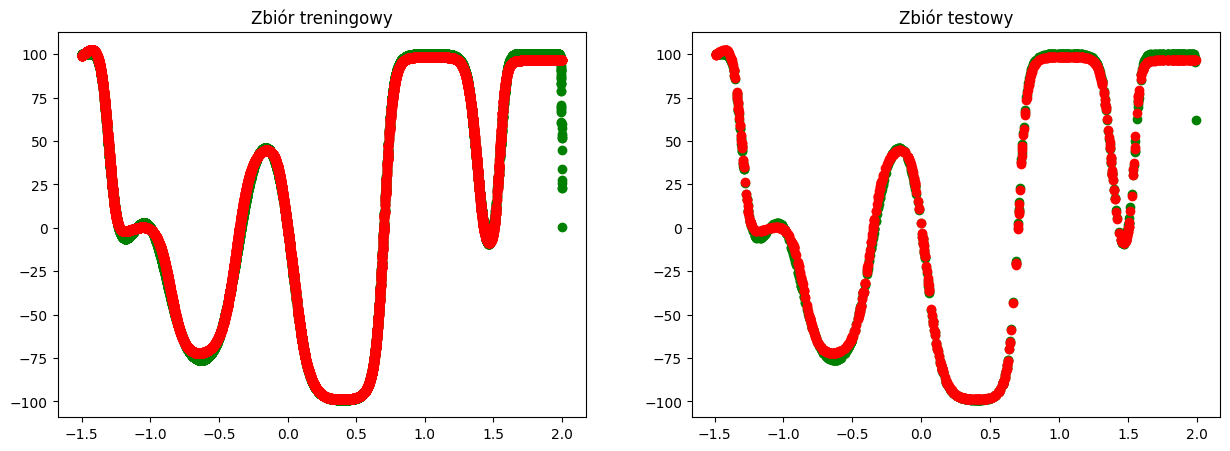

In [28]:
losses_1_t, predictions, predictions_test = evaluate(x, y, x_test, y_test, layers=[1, 30, 1], epochs=1000, learning_rate=0.02, method='SGD', batch_size=64, init_method='uniform', activation_fun='tanh')

##### 1 layer, ReLU

MSE na zbiorze testowym: 5221.460523924665oss test: 5221.460523924665


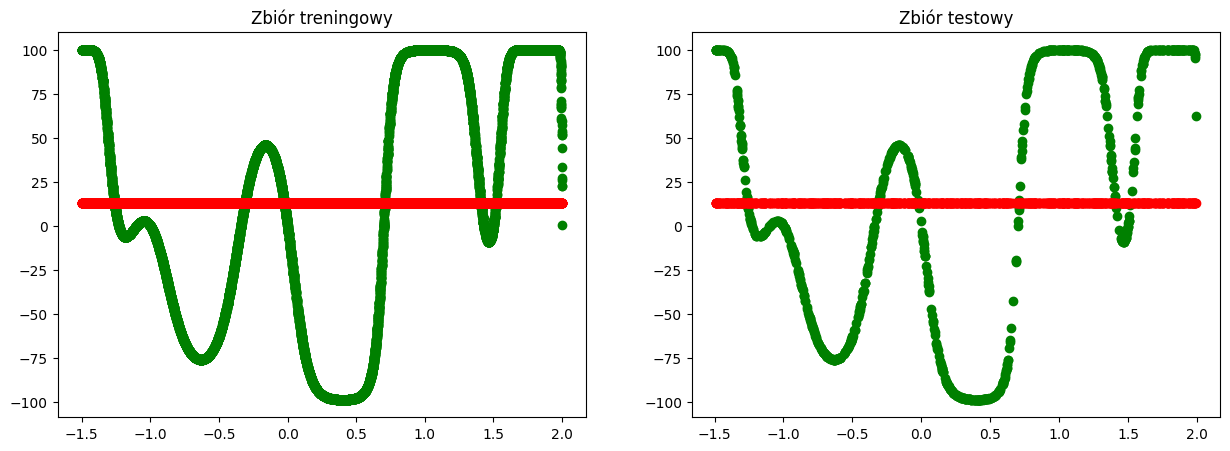

In [29]:
losses_1_r, predictions, predictions_test = evaluate(x, y, x_test, y_test, layers=[1, 30, 1], epochs=1000, learning_rate=0.02, method='SGD', batch_size=64, init_method='uniform', activation_fun='relu')

##### 2 layers, sigmoid

MSE na zbiorze testowym: 2.606810277595353oss test: 2.61981312990788577


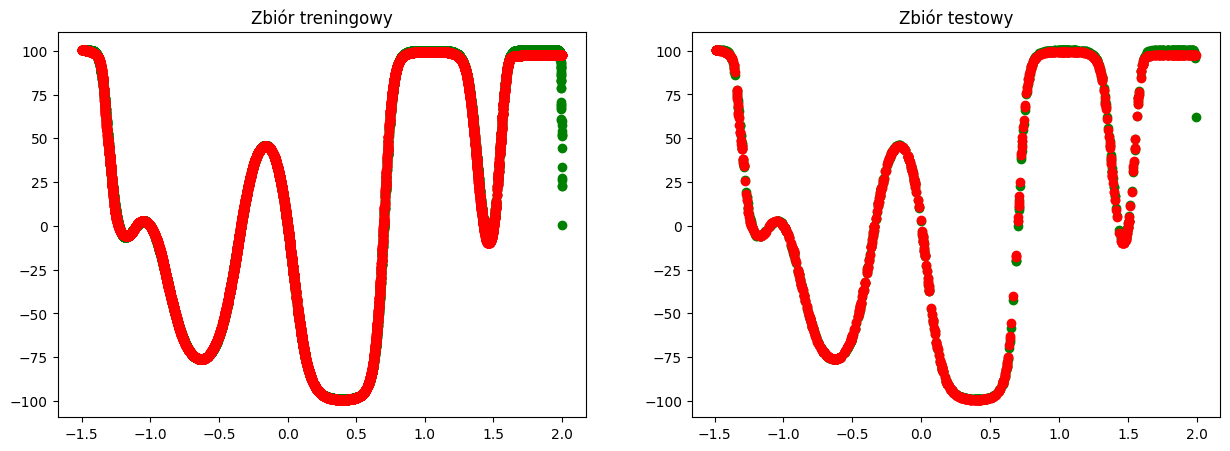

In [30]:
losses_2_s, predictions, predictions_test = evaluate(x, y, x_test, y_test, layers=[1, 30, 60, 1], epochs=1000, learning_rate=0.02, batch_size=64, method='SGD', init_method='uniform', activation_fun='sigmoid')

##### 2 layers, linear

MSE na zbiorze testowym: 4442.1067048585155ss test: 4442.1054834134657


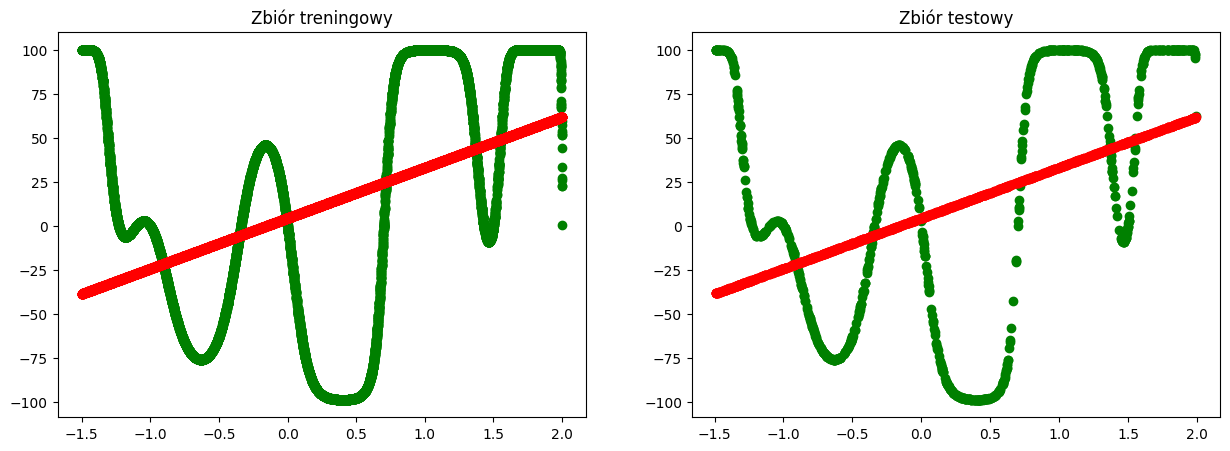

In [31]:
losses_2_l, predictions, predictions_test = evaluate(x, y, x_test, y_test, layers=[1, 30, 60, 1], epochs=1000, learning_rate=0.001, method='SGD', batch_size=64, init_method='uniform', activation_fun='linear')

##### 2 layers, tanh

MSE na zbiorze testowym: 9.496773292781898ss test: 9.170632463083335354


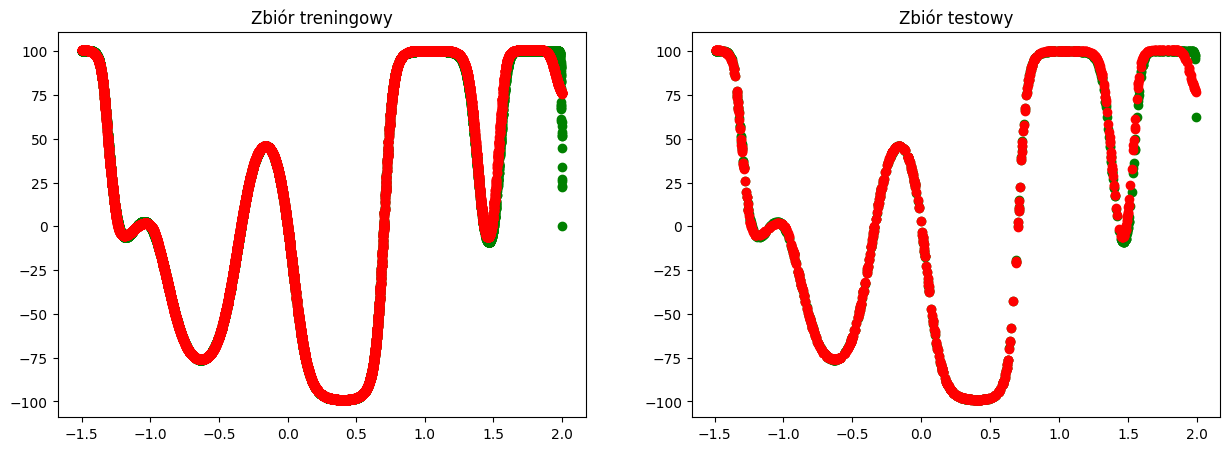

In [32]:
losses_2_t, predictions, predictions_test = evaluate(x, y, x_test, y_test, layers=[1, 30, 60, 1], epochs=1000, learning_rate=0.001, method='SGD', batch_size=64, init_method='uniform', activation_fun='tanh')

##### 2 layers, ReLU

MSE na zbiorze testowym: 6.8202168616519305ss test: 6.73754769371236425


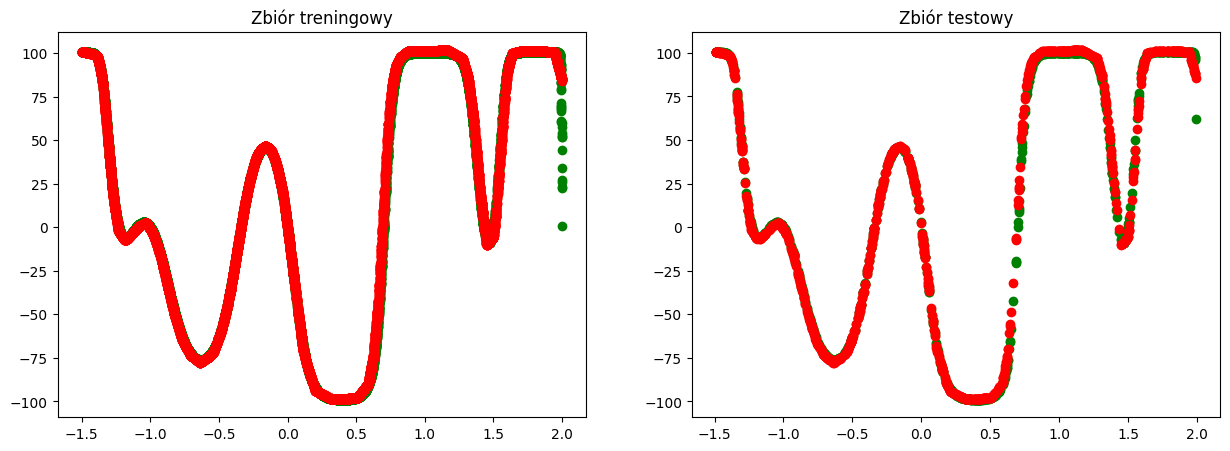

In [33]:
losses_2_r, predictions, predictions_test = evaluate(x, y, x_test, y_test, layers=[1, 30, 60, 1], epochs=1000, learning_rate=0.001, method='SGD', batch_size=64, init_method='uniform', activation_fun='relu')

##### 3 layers, sigmoid

MSE na zbiorze testowym: 17.012329553440544ss test: 5.55774335609788484


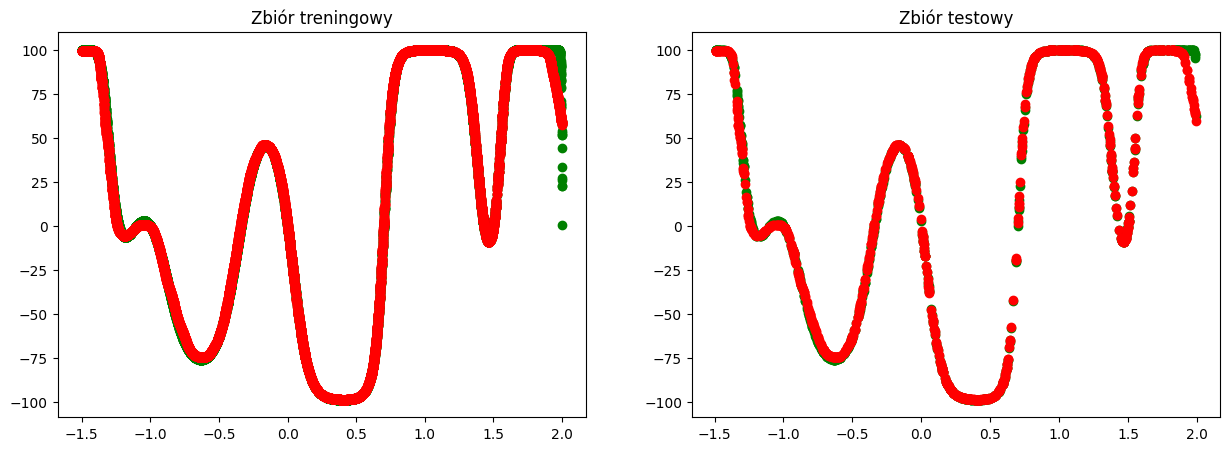

In [34]:
losses_3_s, predictions, predictions_test = evaluate(x, y, x_test, y_test, layers=[1, 30, 60, 90, 1], epochs=400, learning_rate=0.02, method='SGD', batch_size=64, init_method='uniform', activation_fun='sigmoid')

##### 3 layers, linear

MSE na zbiorze testowym: 4435.021021683599oss test: 4435.0937402165289


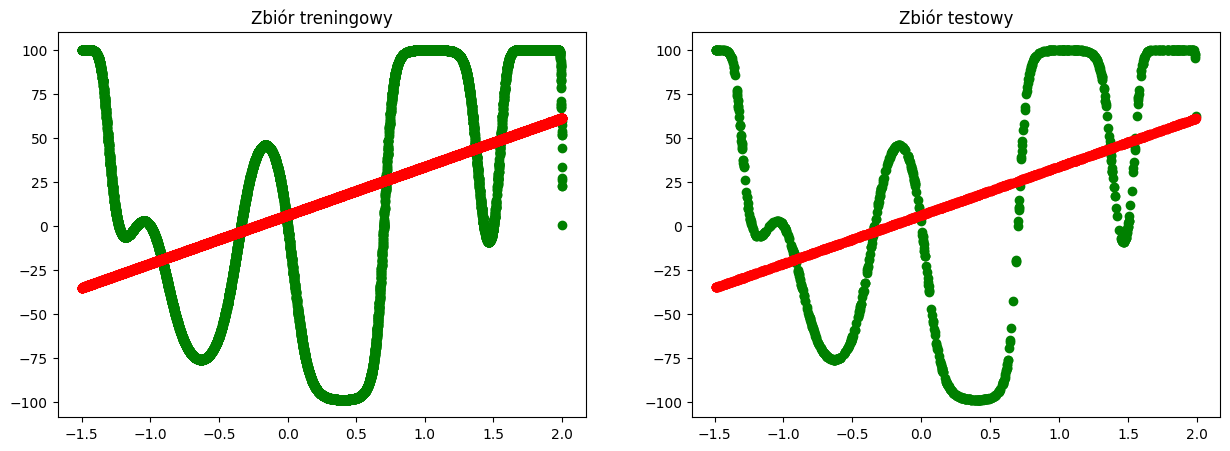

In [35]:
losses_3_l, predictions, predictions_test = evaluate(x, y, x_test, y_test, layers=[1, 30, 60, 90, 1], epochs=400, learning_rate=0.0001, method='SGD', batch_size=64, init_method='uniform', activation_fun='linear')

##### 3 layers, tanh

MSE na zbiorze testowym: 15.673758519283572oss test: 15.657587645862826


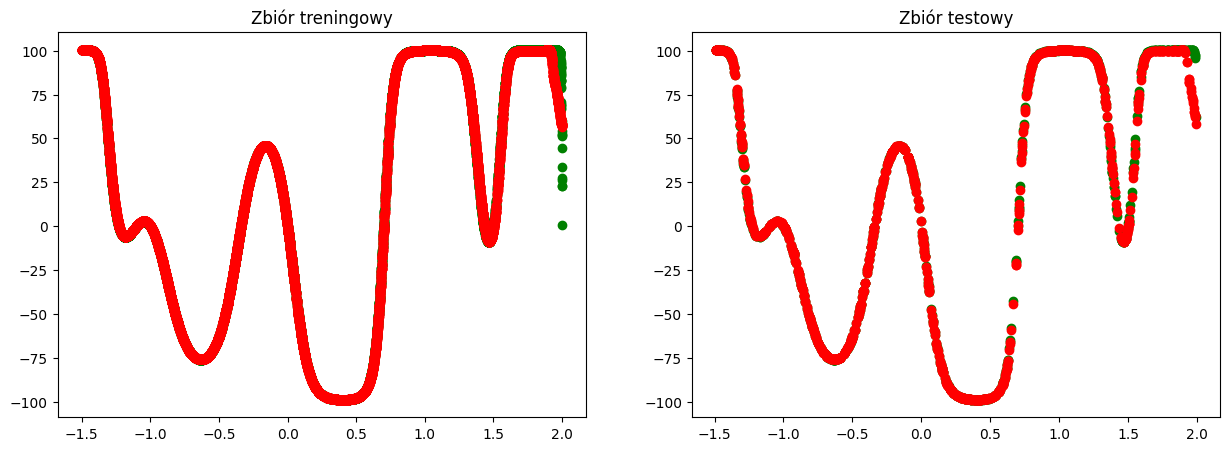

In [22]:
losses_3_t, predictions, predictions_test = evaluate(x, y, x_test, y_test, layers=[1, 30, 60, 90, 1], epochs=400, learning_rate=0.001, method='SGD', batch_size=32, init_method='uniform', activation_fun='tanh')

##### 3 layers, ReLU

MSE na zbiorze testowym: 7.963356638713395oss test: 8.07485287451275472


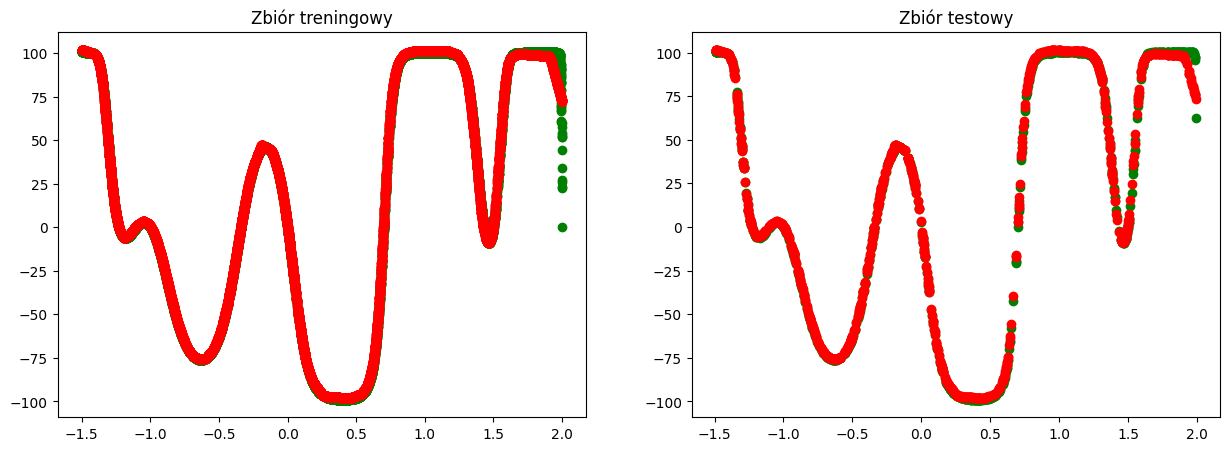

In [24]:
losses_3_r, predictions, predictions_test = evaluate(x, y, x_test, y_test, layers=[1, 30, 60, 90, 1], epochs=400, learning_rate=0.0002, method='SGD', batch_size=64, init_method='uniform', activation_fun='relu')

#### summary of tests on multimodal large set

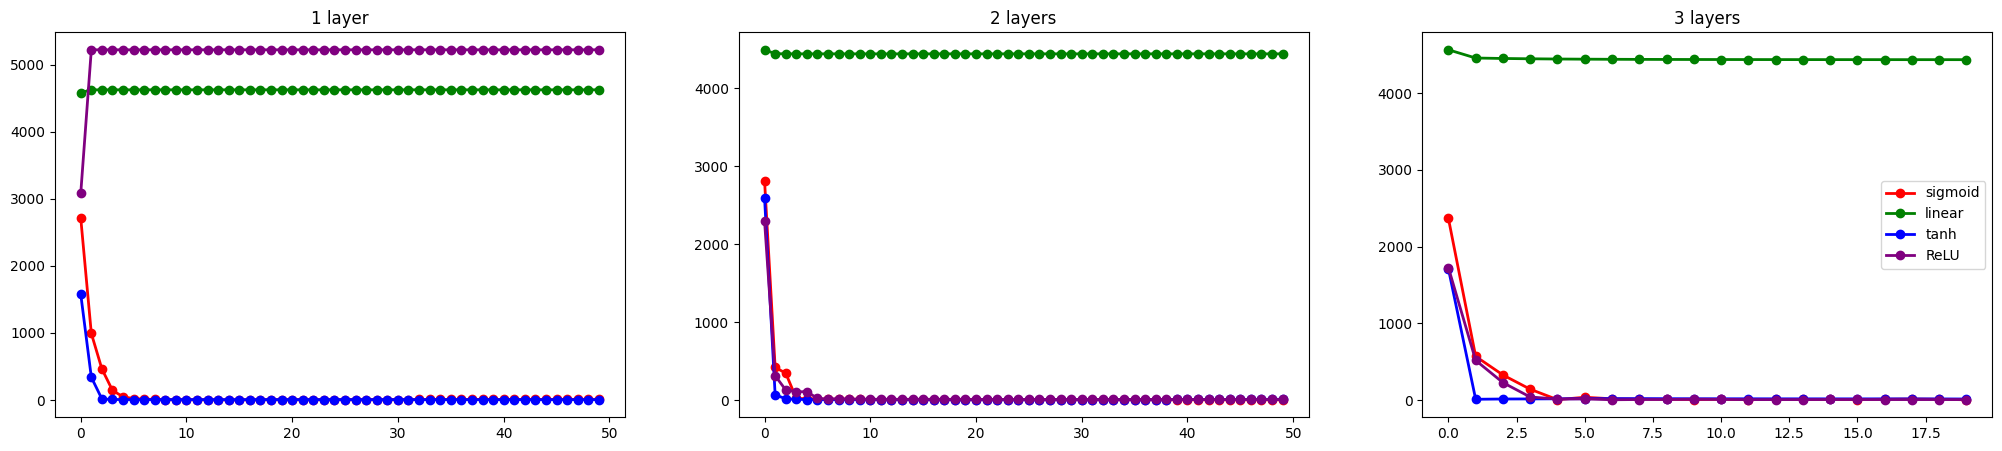

In [40]:
epochs_1=range(0, 1000//20)
epochs_2=range(0, 1000//20)
epochs_3=range(0, 400//20)
plt.subplots(1, 3, figsize=(25, 5))
plt.subplot(1, 3, 1)
plt.plot(epochs_1, losses_1_s, color='red', marker='o', linewidth=2, label='sigmoid')
plt.plot(epochs_1, losses_1_l, color='green', marker='o', linewidth=2, label='linear')
plt.plot(epochs_1, losses_1_t, color='blue', marker='o', linewidth=2, label='tanh')
plt.plot(epochs_1, losses_1_r, color='purple', marker='o', linewidth=2, label='ReLU')
plt.title("1 layer")
plt.subplot(1, 3, 2)
plt.plot(epochs_2, losses_2_s, color='red', marker='o', linewidth=2, label='sigmoid')
plt.plot(epochs_2, losses_2_l, color='green', marker='o', linewidth=2, label='linear')
plt.plot(epochs_2, losses_2_t, color='blue', marker='o', linewidth=2, label='tanh')
plt.plot(epochs_2, losses_2_r, color='purple', marker='o', linewidth=2, label='ReLU')
plt.title("2 layers")
plt.subplot(1, 3, 3)
plt.plot(epochs_3, losses_3_s, color='red', marker='o', linewidth=2, label='sigmoid')
plt.plot(epochs_3, losses_3_l, color='green', marker='o', linewidth=2, label='linear')
plt.plot(epochs_3, losses_3_t, color='blue', marker='o', linewidth=2, label='tanh')
plt.plot(epochs_3, losses_3_r, color='purple', marker='o', linewidth=2, label='ReLU')
plt.title("3 layers")
plt.legend()
plt.show()

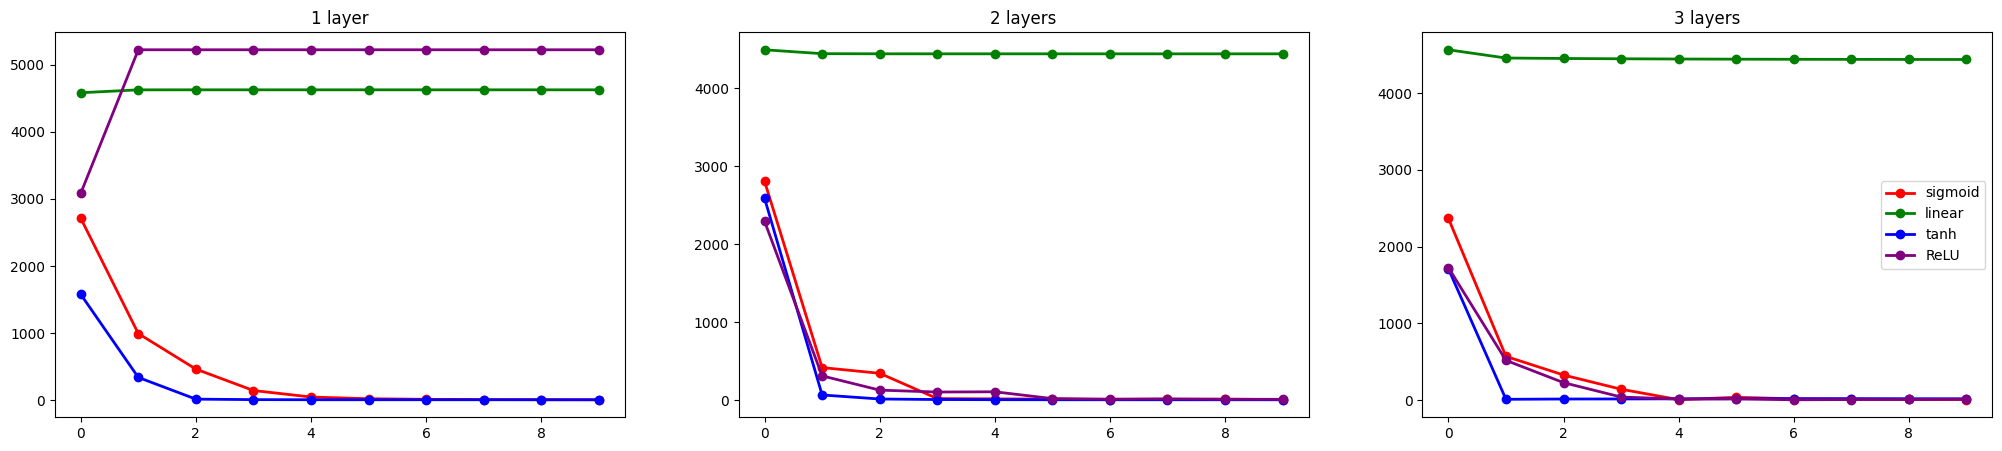

In [42]:
epochs_1=range(0, 10)
epochs_2=range(0, 10)
epochs_3=range(0, 10)
plt.subplots(1, 3, figsize=(25, 5))
plt.subplot(1, 3, 1)
plt.plot(epochs_1, losses_1_s[0:10], color='red', marker='o', linewidth=2, label='sigmoid')
plt.plot(epochs_1, losses_1_l[0:10], color='green', marker='o', linewidth=2, label='linear')
plt.plot(epochs_1, losses_1_t[0:10], color='blue', marker='o', linewidth=2, label='tanh')
plt.plot(epochs_1, losses_1_r[0:10], color='purple', marker='o', linewidth=2, label='ReLU')
plt.title("1 layer")
plt.subplot(1, 3, 2)
plt.plot(epochs_2, losses_2_s[0:10], color='red', marker='o', linewidth=2, label='sigmoid')
plt.plot(epochs_2, losses_2_l[0:10], color='green', marker='o', linewidth=2, label='linear')
plt.plot(epochs_2, losses_2_t[0:10], color='blue', marker='o', linewidth=2, label='tanh')
plt.plot(epochs_2, losses_2_r[0:10], color='purple', marker='o', linewidth=2, label='ReLU')
plt.title("2 layers")
plt.subplot(1, 3, 3)
plt.plot(epochs_3, losses_3_s[0:10], color='red', marker='o', linewidth=2, label='sigmoid')
plt.plot(epochs_3, losses_3_l[0:10], color='green', marker='o', linewidth=2, label='linear')
plt.plot(epochs_3, losses_3_t[0:10], color='blue', marker='o', linewidth=2, label='tanh')
plt.plot(epochs_3, losses_3_r[0:10], color='purple', marker='o', linewidth=2, label='ReLU')
plt.title("3 layers")
plt.legend()
plt.show()

In choosing the best set, I will take into account the speed of convergence for different architectures and the computation time, which depends mainly on the number of epochs and the size of the architecture.

It seems that the most advantageous choice will be to choose architectures:
* with 1 hidden layer and tanh activation function. 
* with 2 hidden layers and tanh activation function.

It should also be enough to do fewer iterations than I did in testing.

## steps-large

In [43]:
data_train = pd.read_csv('../data/regression/steps-large-training.csv', index_col = 0)
data_test = pd.read_csv('../data/regression/steps-large-test.csv', index_col = 0)
x = data_train[['x']]
y = data_train[['y']]
x_test = data_test[['x']]
y_test = data_test[['y']]

##### 1 layer, tanh

MSE na zbiorze testowym: 25.52316357711581Loss test: 26.159333321404258


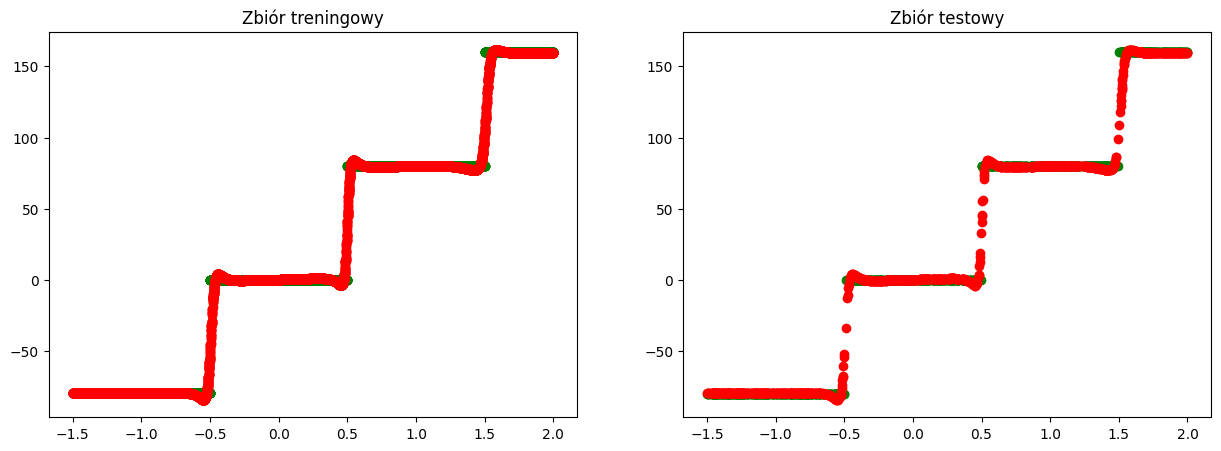

In [45]:
losses_1_t_SL, predictions, predictions_test = evaluate(x, y, x_test, y_test, layers=[1, 30, 1], epochs=400, learning_rate=0.02, method='SGD', batch_size=64, init_method='uniform', activation_fun='tanh')

2 layers, tanh

MSE na zbiorze testowym: 8.316923150517631ss test: 9.192174947074792451


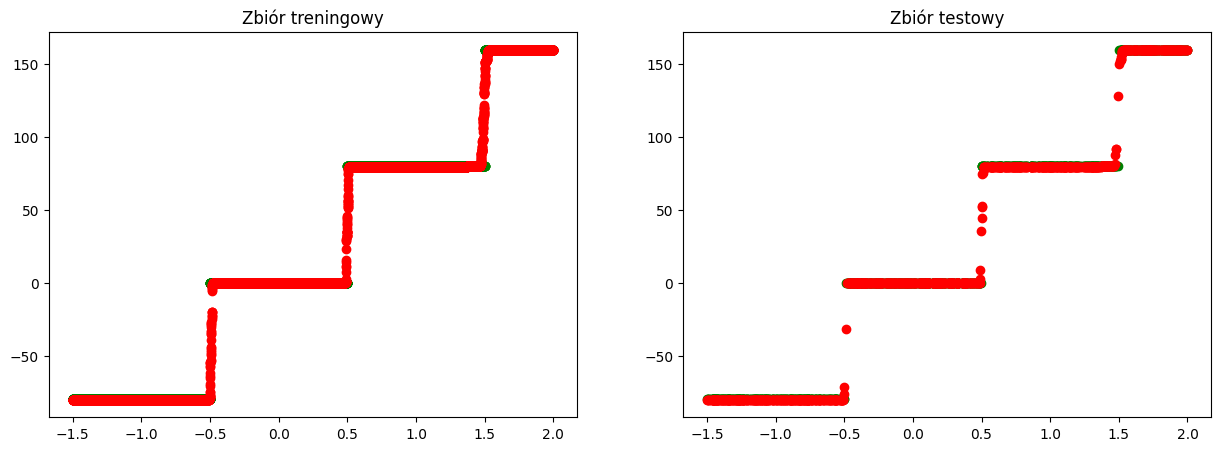

In [46]:
losses_2_t_SL, predictions, predictions_test = evaluate(x, y, x_test, y_test, layers=[1, 30, 60, 1], epochs=400, learning_rate=0.02, method='SGD', batch_size=64, init_method='uniform', activation_fun='tanh')

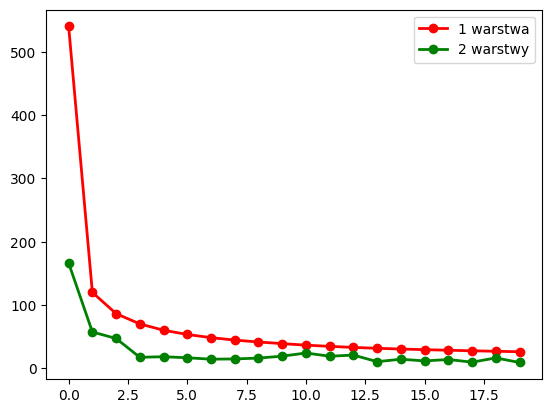

In [47]:
plt.plot(range(0, 400//20), losses_1_t_SL[0:20], color='red', marker='o', linewidth=2, label='1 warstwa')
plt.plot(range(0, 400//20), losses_2_t_SL[0:20], color='green', marker='o', linewidth=2, label='2 warstwy')
plt.legend()
plt.show()

## rings5-regular

In [23]:
data_train = pd.read_csv('../data/classification/rings5-regular-training.csv')
data_test = pd.read_csv('../data/classification/rings5-regular-test.csv')
x = np.asarray(data_train.iloc[:,0:2])
x_test = np.asarray(data_test.iloc[:,0:2])
y = np.asarray(data_train.iloc[:,2]).reshape(-1, 1)
y_test = data_test['c']

1 layer, tanh

F1 na zbiorze testowym: 0.8498561366446852 Loss test: 0.84941010668459325


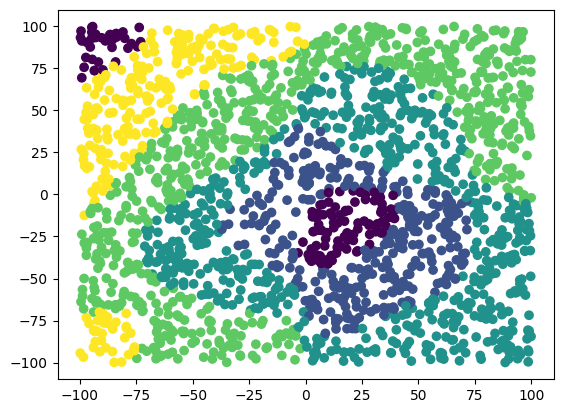

In [34]:
weights, biases, losses_1_t_R5 = train(x, y, x_test, y_test, layers=[2, 30, 5], epochs = 10000, learning_rate = 0.02, method='SGD', batch_size=64, activation_fun='tanh', activation_fun_out='softmax')        
predictions_b,z = feedforward(x_test, weights, biases, activation_fun='tanh', activation_fun_out='softmax')
result = np.argmax(predictions_b[-1], axis = 1)
print("F1 na zbiorze testowym:", f1_score(data_test['c'], result, average = 'macro'))
plt.scatter(data_test['x'], data_test['y'], c=result)
plt.show()

2 layers, tanh

F1 na zbiorze testowym: 0.9396083048199827 Loss test: 0.9396083048199827


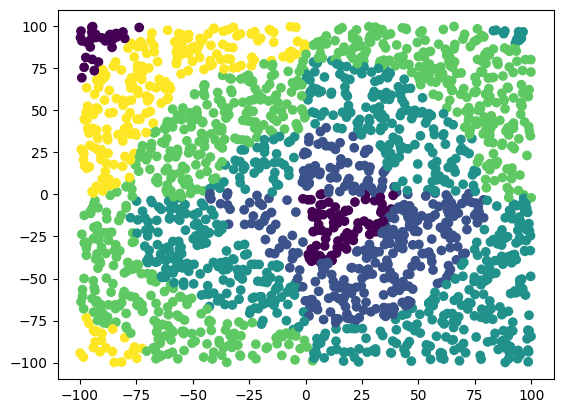

In [35]:
weights, biases, losses_2_t_R5 = train(x, y, x_test, y_test, layers=[2, 30, 60, 5], epochs = 10000, learning_rate = 0.02, method='SGD', batch_size=64, activation_fun='tanh', activation_fun_out='softmax')        
predictions_b,z = feedforward(x_test, weights, biases,  activation_fun='tanh', activation_fun_out='softmax')
result = np.argmax(predictions_b[-1], axis = 1)
print("F1 na zbiorze testowym:", f1_score(data_test['c'], result, average = 'macro'))
plt.scatter(data_test['x'], data_test['y'], c=result)
plt.show()

In this case, I increased the number of epochs 10 times the original (chosen) model to get satisfactory results. I'll try normalizing the data to see if this would work better.

F1 na zbiorze testowym: 0.7542359429107311 Loss test: 0.75286832309907975


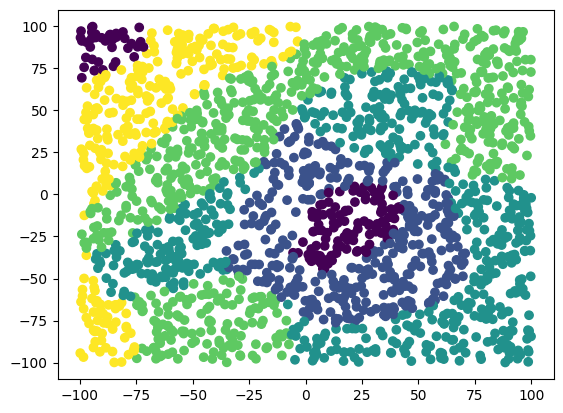

In [37]:
x = np.asarray(data_train.iloc[:,0:2])
x_test = np.asarray(data_test.iloc[:,0:2])
y = np.asarray(data_train.iloc[:,2]).reshape(-1, 1)
y_test = data_test['c']
scaler_x = StandardScaler()
scaler_x.fit(x)
x = scaler_x.transform(x)
x_test = scaler_x.transform(x_test)

weights, biases, losses_1_t_R5s = train(x, y, x_test, y_test, layers=[2, 30, 5], epochs = 5000, learning_rate = 0.02, method='SGD', batch_size=64, activation_fun='tanh', activation_fun_out='softmax')        
predictions_b,z = feedforward(x_test, weights, biases, activation_fun='tanh', activation_fun_out='softmax')
result = np.argmax(predictions_b[-1], axis = 1)
print("F1 na zbiorze testowym:", f1_score(data_test['c'], result, average = 'macro'))
plt.scatter(data_test['x'], data_test['y'], c=result)
plt.show()

F1 na zbiorze testowym: 0.9326371745496758 Loss test: 0.9326371745496758


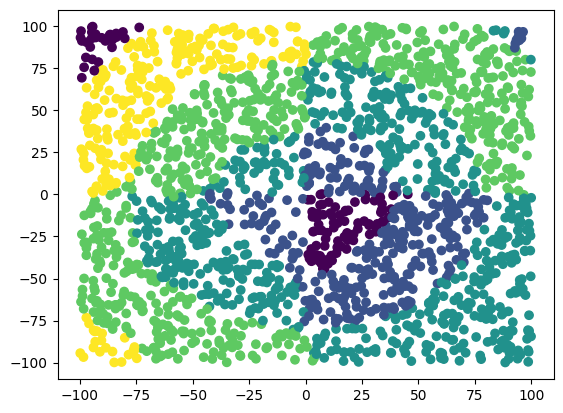

In [38]:
x = np.asarray(data_train.iloc[:,0:2])
x_test = np.asarray(data_test.iloc[:,0:2])
y = np.asarray(data_train.iloc[:,2]).reshape(-1, 1)
y_test = data_test['c']
scaler_x = StandardScaler()
scaler_x.fit(x)
x = scaler_x.transform(x)
x_test = scaler_x.transform(x_test)

weights, biases, losses_2_t_R5s = train(x, y, x_test, y_test, layers=[2, 30, 60, 5], epochs = 5000, learning_rate = 0.2, method='SGD', batch_size=64, activation_fun='tanh', activation_fun_out='softmax')        
predictions_b,z = feedforward(x_test, weights, biases, activation_fun='tanh', activation_fun_out='softmax')
result = np.argmax(predictions_b[-1], axis = 1)
print("F1 na zbiorze testowym:", f1_score(data_test['c'], result, average = 'macro'))
plt.scatter(data_test['x'], data_test['y'], c=result)
plt.show()

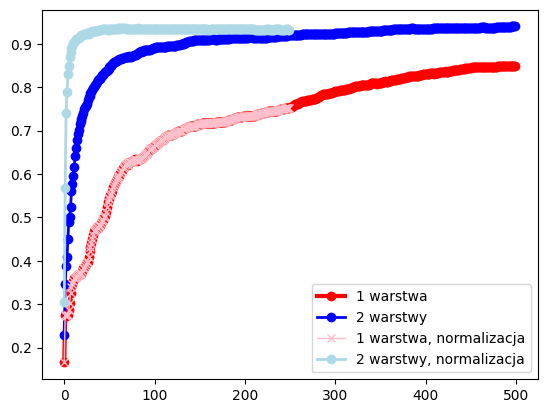

In [50]:
plt.plot(range(0, 10000//20), losses_1_t_R5[0:500], color='red', marker='o', linewidth=3, label='1 warstwa')
plt.plot(range(0, 10000//20), losses_2_t_R5[0:500], color='blue', marker='o', linewidth=2, label='2 warstwy')
plt.plot(range(0, 5000//20), losses_1_t_R5s[0:250], color='pink', marker='x', linewidth=1, label='1 warstwa, normalizacja')
plt.plot(range(0, 5000//20), losses_2_t_R5s[0:250], color='lightblue', marker='o', linewidth=2, label='2 warstwy, normalizacja')
plt.legend()
plt.show()

As spend in the case of achitecture with one layer normalization does not matter, but in the case of two layers, thanks to normalization, the results are obtained faster.

## rings3-regular

In [40]:
data_train = pd.read_csv('../data/classification/rings3-regular-training.csv')
data_test = pd.read_csv('../data/classification/rings3-regular-test.csv')
x = np.asarray(data_train.iloc[:,0:2])
x_test = np.asarray(data_test.iloc[:,0:2])
y = np.asarray(data_train.iloc[:,2]).reshape(-1, 1)
y_test = data_test['c']

1 layer, tanh

F1 na zbiorze testowym: 0.6529333129436697Loss test: 0.6056765511855415


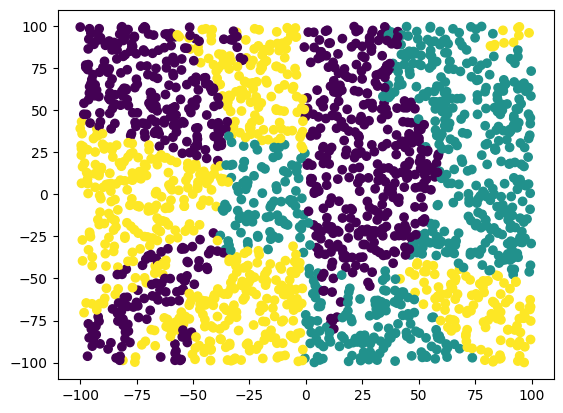

In [41]:
weights, biases, losses_1_t_R3 = train(x, y, x_test, y_test, layers=[2, 30, 3], epochs = 1000, learning_rate = 0.02, method='SGD', batch_size=64, activation_fun='tanh', activation_fun_out='softmax')        
predictions_b,z = feedforward(x_test, weights, biases, activation_fun='tanh', activation_fun_out='softmax')
result = np.argmax(predictions_b[-1], axis = 1)
print("F1 na zbiorze testowym:", f1_score(data_test['c'], result, average = 'macro'))
plt.scatter(data_test['x'], data_test['y'], c=result)
plt.show()

2 layers, tanh

F1 na zbiorze testowym: 0.5473211540381352Loss test: 0.694654323841413353


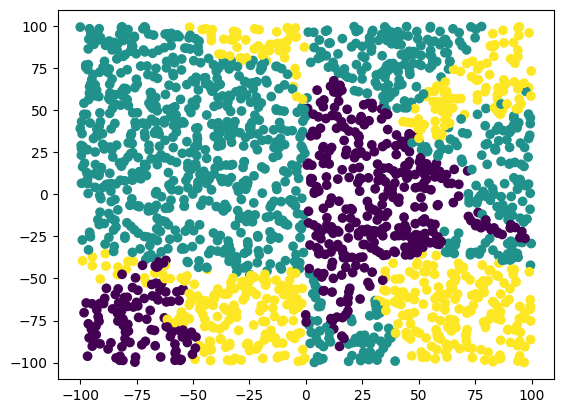

In [42]:
weights, biases, losses_2_t_R3 = train(x, y, x_test, y_test, layers=[2, 30, 60, 3], epochs = 1000, learning_rate = 0.02, method='SGD', batch_size=64, activation_fun='tanh', activation_fun_out='softmax')        
predictions_b,z = feedforward(x_test, weights, biases, activation_fun='tanh', activation_fun_out='softmax')
result = np.argmax(predictions_b[-1], axis = 1)
print("F1 na zbiorze testowym:", f1_score(data_test['c'], result, average = 'macro'))
plt.scatter(data_test['x'], data_test['y'], c=result)
plt.show()

The selected models did not work satisfactorily well, so in this case I will also try to normalize the data.

F1 na zbiorze testowym: 0.8181517265765809Loss test: 0.8169151111587859


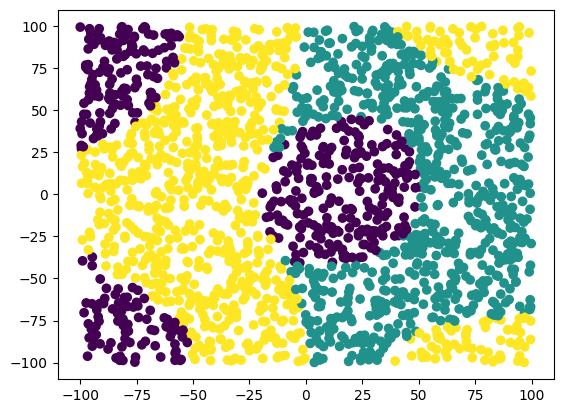

In [43]:
x = np.asarray(data_train.iloc[:,0:2])
x_test = np.asarray(data_test.iloc[:,0:2])
y = np.asarray(data_train.iloc[:,2]).reshape(-1, 1)
y_test = data_test['c']
scaler_x = StandardScaler()
scaler_x.fit(x)
x = scaler_x.transform(x)
x_test = scaler_x.transform(x_test)

weights, biases, losses_1_t_R3s = train(x, y, x_test, y_test, layers=[2, 30, 3], epochs = 1000, learning_rate = 0.02, method='SGD', batch_size=64, activation_fun='tanh', activation_fun_out='softmax')        
predictions_b,z = feedforward(x_test, weights, biases, activation_fun='tanh', activation_fun_out='softmax')
result = np.argmax(predictions_b[-1], axis = 1)
print("F1 na zbiorze testowym:", f1_score(data_test['c'], result, average = 'macro'))
plt.scatter(data_test['x'], data_test['y'], c=result)
plt.show()

F1 na zbiorze testowym: 0.9482684921798917Loss test: 0.9476549738088922


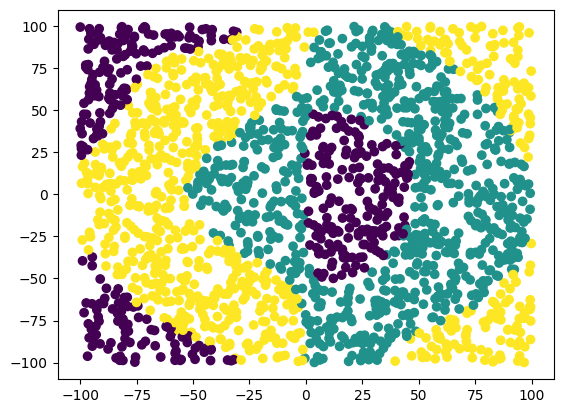

In [44]:
x = np.asarray(data_train.iloc[:,0:2])
x_test = np.asarray(data_test.iloc[:,0:2])
y = np.asarray(data_train.iloc[:,2]).reshape(-1, 1)
y_test = data_test['c']
scaler_x = StandardScaler()
scaler_x.fit(x)
x = scaler_x.transform(x)
x_test = scaler_x.transform(x_test)

weights, biases, losses_2_t_R3s = train(x, y, x_test, y_test, layers=[2, 30, 60, 3], epochs = 1000, learning_rate = 0.02, method='SGD', batch_size=64, activation_fun='tanh', activation_fun_out='softmax')        
predictions_b,z = feedforward(x_test, weights, biases, activation_fun='tanh', activation_fun_out='softmax')
result = np.argmax(predictions_b[-1], axis = 1)
print("F1 na zbiorze testowym:", f1_score(data_test['c'], result, average = 'macro'))
plt.scatter(data_test['x'], data_test['y'], c=result)
plt.show()

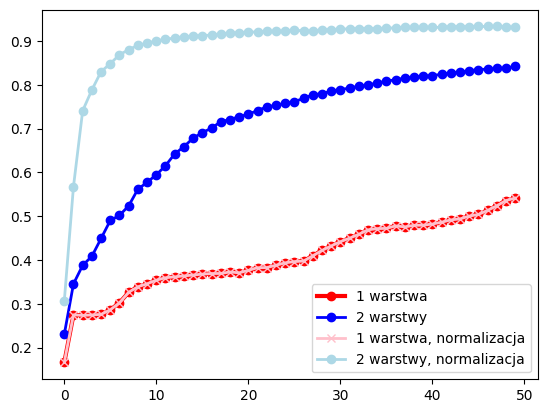

In [49]:
plt.plot(range(0, 1000//20), losses_1_t_R5[0:50], color='red', marker='o', linewidth=3, label='1 warstwa')
plt.plot(range(0, 1000//20), losses_2_t_R5[0:50], color='blue', marker='o', linewidth=2, label='2 warstwy')
plt.plot(range(0, 1000//20), losses_1_t_R5s[0:50], color='pink', marker='x', linewidth=2, label='1 warstwa, normalizacja')
plt.plot(range(0, 1000//20), losses_2_t_R5s[0:50], color='lightblue', marker='o', linewidth=2, label='2 warstwy, normalizacja')
plt.legend()
plt.show()

Again, normalization changes nothing for a single-layer architecture, but for two it speeds up convergence.


From the tests conducted, it appears that architectures and parameters that are good for regression perform well on other regression problems, but for classification problems, more epochs or data normalization is needed to achieve good results.